In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

## Mean and standard deviation

Applying transforms on input images. Starting with just a `Resize(32, 32)` to get all tensors to be same shape.

Plan to try : - Multiple Augmentations
              - Normalize with calculating the Mean and Std for the dataset

ImageNet mean and standard deviation for normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

**Dataset mean: tensor([0.3417, 0.3126, 0.3216])**

**Dataset std: tensor([0.1680, 0.1678, 0.1780])**

In [2]:
# Calculate mean and standard deviation for the dataset
# def calc_mean_std(dataset):
#     loader = DataLoader(dataset)
#     mean, std = 0. , 0.
#     for images, _ in loader:
#         batch_samples = images.size(0)
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#     mean /= len(loader.dataset)
#     std /= len(loader.dataset)
#     return mean, std
    
# mean, std = calc_mean_std(training_data)
# print(f"Dataset mean: {mean}")
# print(f"Dataset std: {std}")

In [3]:
# Define a transform with compose to pre-process the input images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [4]:
train_data = datasets.GTSRB(root='data', download=True, split='train', transform=transform)
test_data = datasets.GTSRB(root='data', download=True, split='test', transform=transform)

print(f'Length of train data: {len(train_data)}')
print(f'Length of train data: {len(test_data)}')

Length of train data: 26640
Length of train data: 12630


In [5]:
class_maps = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
            }

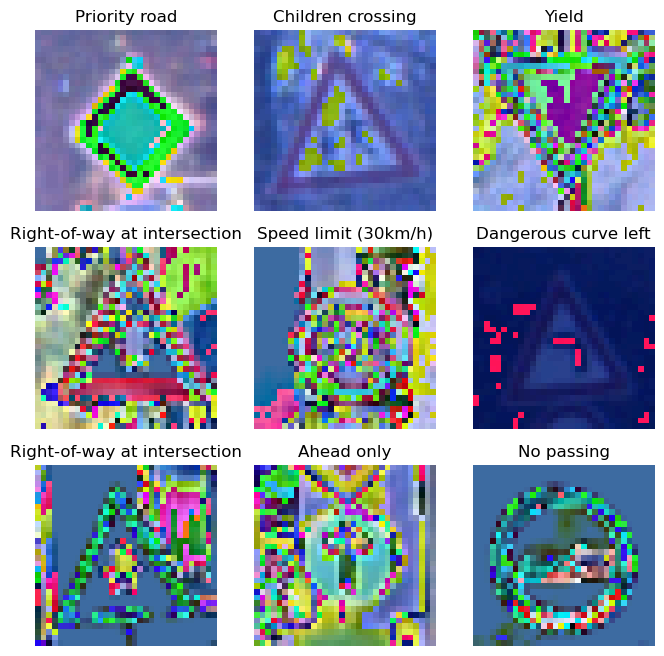

In [6]:
# Display image and label.
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_maps[label])
    plt.axis("off")
    plt.imshow(ToPILImage()(img))
plt.show()

In [7]:
BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Set device to cuda if available or cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"------------- Using {device} -----------")

------------- Using cuda -----------


## Model class

In [9]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 43)  # 43 classes in GTSRB
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
model = NeuralNet().to(device)
print(model)

NeuralNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
         
        #Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # back propagate and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss = loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            
            

In [17]:
epochs = 40
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!!")

Epoch 1
-------------------------------
loss: 1.935202 [   64/26640]
loss: 2.023435 [ 6464/26640]
loss: 2.013447 [12864/26640]
loss: 2.121707 [19264/26640]
loss: 1.980731 [25664/26640]
Test Error: 
 Accuracy: 36.6%, Avg loss: 0.013187 

Epoch 2
-------------------------------
loss: 1.792312 [   64/26640]
loss: 1.768168 [ 6464/26640]
loss: 1.841347 [12864/26640]
loss: 1.773740 [19264/26640]
loss: 2.044622 [25664/26640]
Test Error: 
 Accuracy: 33.6%, Avg loss: 0.013361 

Epoch 3
-------------------------------
loss: 1.946046 [   64/26640]
loss: 1.592671 [ 6464/26640]
loss: 1.905948 [12864/26640]
loss: 1.812382 [19264/26640]
loss: 1.901500 [25664/26640]
Test Error: 
 Accuracy: 35.6%, Avg loss: 0.013063 

Epoch 4
-------------------------------
loss: 2.037499 [   64/26640]
loss: 1.901945 [ 6464/26640]
loss: 1.637304 [12864/26640]
loss: 1.446854 [19264/26640]
loss: 1.660324 [25664/26640]
Test Error: 
 Accuracy: 40.0%, Avg loss: 0.013236 

Epoch 5
-------------------------------
loss: 1.7493

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")